In [27]:
import glob as gl
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import ks_2samp, kruskal,ttest_ind,spearmanr,pearsonr
from scipy import stats
import seaborn as sns
import shutil

In [40]:
# All metadata
in_folder = "./Protein_data"
treatments = ["cntl","CNIH2"]
x_labels = ["Cntl","CNIH-2"]
compartments = ["soma"]
CNIH2_validation_mRNA_file = os.path.join(in_folder,"CNIH2_validation_mRNA.pkl")
CNIH2_validation_protein_file = os.path.join(in_folder,"CNIH2_validation_protein.pkl")
CNIH2_validation_mRNA_meta_file = os.path.join(in_folder,"CNIH2_validation_mRNA_meta.pkl")
CNIH2_validation_protein_meta_file = os.path.join(in_folder,"CNIH2_validation_protein_meta.pkl")

In [41]:
op_folder = "../Figures/CNIH2_validation"
def CreateFolderRecursive(folder):
    """
        function creates folders upto  a path recursively
        arguments : folderpath
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
CreateFolderRecursive(op_folder)

In [42]:
CNIH_prot_val_data = pd.read_pickle(CNIH2_validation_protein_file)
CNIH_prot_val_meta_data = pd.read_pickle(CNIH2_validation_protein_meta_file)
CNIH_mRNA_val_data = pd.read_pickle(CNIH2_validation_mRNA_file)
CNIH_mRNA_val_meta_data = pd.read_pickle(CNIH2_validation_mRNA_meta_file)
cell_roi_data = CNIH_prot_val_data.groupby(["cell_id","treatment","compartment"])
cell_roi_meta_data = CNIH_prot_val_meta_data.groupby(["cell_id","treatment","compartment"])
cell_roi_mRNA_data = CNIH_mRNA_val_data.groupby(["cell_id","treatment","compartment"])
cell_roi_mRNA_meta_data = CNIH_mRNA_val_meta_data.groupby(["cell_id","treatment","compartment"])

In [43]:
cell_roi_data.size(),cell_roi_meta_data.size()

(cell_id  treatment  compartment
 1        CNIH2      soma           16
          cntl       soma           37
 2        CNIH2      soma            5
          cntl       soma           59
 3        CNIH2      soma            3
                                    ..
 61       cntl       soma            8
 62       cntl       soma            6
 64       cntl       soma            9
 65       cntl       soma           11
 66       cntl       soma           14
 Length: 71, dtype: int64,
 cell_id  treatment  compartment
 1        CNIH2      soma           1
          cntl       soma           1
 2        CNIH2      soma           1
          cntl       soma           1
 3        CNIH2      soma           1
                                   ..
 61       cntl       soma           1
 62       cntl       soma           1
 64       cntl       soma           1
 65       cntl       soma           1
 66       cntl       soma           1
 Length: 72, dtype: int64)

In [44]:
cell_roi_mRNA_data.size(),cell_roi_mRNA_meta_data.size()

(cell_id  treatment  compartment
 1        CNIH2      soma           165
          cntl       soma           201
 2        CNIH2      soma            20
          cntl       soma           190
 3        CNIH2      soma             9
          cntl       soma           184
 4        CNIH2      soma             3
          cntl       soma           373
 5        CNIH2      soma             6
          cntl       soma           214
 6        CNIH2      soma             5
          cntl       soma           113
 7        CNIH2      soma            45
          cntl       soma           550
 8        CNIH2      soma            14
          cntl       soma           206
 9        CNIH2      soma             4
 10       CNIH2      soma             6
 11       CNIH2      soma             4
 12       CNIH2      soma             3
 13       CNIH2      soma            15
 14       CNIH2      soma            36
 15       CNIH2      soma           131
 16       CNIH2      soma             1
 17    

In [45]:
def SaveFigures(filename,ext_list = [".png",".svg",".pdf"],dpi=300):
    """
        function to save figures
        required arguments:
            filename
    """
    plt.tight_layout()
    for ext in ext_list:
        plt.savefig(filename+ext,dpi=dpi)
def AnnotateText(ax,x1,x2,y,h,txt,color,ha='center',va='bottom',fsize=24):
        # print(x,y,txt)
        if not txt == '':
            fac = np.abs(x2-x1)*0.04
            trans = ax.get_xaxis_transform()
            plt.hlines(xmin=x1,xmax=x2, y = y+fac, lw=1.5, color=color)#, transform=trans)
            plt.text((x1+ x2)*0.5,y+h+fac,txt, ha=ha, va=va, color=color,fontsize=fsize)#,transform=trans )
def SwarmBoxCombo(dp,x,y,fbase,xlabel,ylabel,title,Num=True,pairs = [[1,2],[3,4]]):
    # for compa in compartments:
        fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
        xfsize = 30
        ax.tick_params(axis='both', which='major', labelsize=xfsize)
        ax.grid(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # comp_to_analyse = compa
        # order = reversed(treatments)
        hue = "treatment"
        hue_order = treatments
        color_pal = ['k','k']
        data_to_plot = dp#dp[dp["compartment"]==comp_to_analyse]
        hue_plot_params = {
                    'data': data_to_plot,
                    'x': x,
                    'y': y,
                    # "order": order,
                    "hue": hue,
                    "hue_order": hue_order,
                    "palette": color_pal,

                }
        # pairs = [
        #     (('E6',tool_list[0]),('E6',tool_list[1])),
        #     (('E7',tool_list[0]),('E7',tool_list[1]))
        #         ]
        sns.swarmplot(**hue_plot_params,
                      dodge=True,
                      zorder=1,
                      size = 10,
                      # kind="strip",
                      # native_scale=True,
                      alpha = 0.5,
                      edgecolor = "k",
                      linewidth = 2,
                      ax=ax)
        sns.boxplot(**hue_plot_params,
                    fill=False,
                    showmeans=True ,
                    meanprops={"marker": "^",
                       "markeredgecolor": "k",
                       "markerfacecolor":"k",
                       "markersize": "20"},
                    medianprops={'color': '#7c0cb4ff', 'ls': '-', 'lw': 4},
                    width=.8,
                    zorder=3,
                    showfliers=False,
                    gap=1.8,
                    ax=ax)
        if Num:
            comp_data = np.array(data_to_plot.groupby(["compartment","treatment"]).Num.apply(list))#.to_numpy()
            # ax.set_ylim([0.2,1])
        else:
            # print(data_to_plot.head())
            comp_data = np.array(data_to_plot.groupby(["compartment","treatment"]).Density.apply(list))#.to_numpy()
        x_poss = [-0.2,0.2]

        for pdx,pair in enumerate(pairs):
            # print(p_values[p[0]][p[1]])
            ks_res = stats.mannwhitneyu(comp_data[pair[0]-1], comp_data[pair[1]-1])
            print(ks_res.pvalue,comp_data.shape)
            txt = ''
            ymax = np.min([np.max(comp_data[pdx*1+pdx])*1.1,1])
            print(ks_res.pvalue)
            if ks_res.pvalue > 0.05:
                txt= "ns"
            else:
                
                if ks_res.pvalue <= 0.05:
                    txt += '*'
                if ks_res.pvalue <= 0.01:
                    txt += '*'
                if ks_res.pvalue <= 0.001:
                    txt += '*'
            print(txt)
            AnnotateText(ax,x_poss[pair[0]-1],x_poss[pair[1]-1],ymax+0.1*pdx,0.01,txt,'k')
        ax.set_xlabel(xlabel,fontsize=xfsize)
        ax.set_ylabel(ylabel,fontsize=xfsize)
        ax.set_xticks(x_poss,x_labels,rotation=45)
        ax.set_title(title,fontsize=xfsize)
        # plt.axvline(x=0.5,color = "k",linestyle="--")
        plt.legend([],[],frameon=False)
        # ax.set( yscale="log")
        # ax.set_ylim([0,0.25])
        ax.text(x_poss[0],0.2,compartments[0],fontsize=xfsize)
        # ax.text(x_poss[2],0.2,compartments[1],fontsize=xfsize)
        SaveFigures("{}/{}".format(op_folder,fbase))
       

        

In [46]:
newprot_counts = CNIH_prot_val_data.groupby(["cell_id","treatment","compartment"]).count().PID
newprot_counts.head()

cell_id  treatment  compartment
1        CNIH2      soma           16
         cntl       soma           37
2        CNIH2      soma            5
         cntl       soma           59
3        CNIH2      soma            3
Name: PID, dtype: int64

In [47]:
ROI_areas = cell_roi_meta_data.sum().ROI_AOL
ROI_areas

cell_id  treatment  compartment
1        CNIH2      soma           116.766333
         cntl       soma           241.513009
2        CNIH2      soma           176.649656
         cntl       soma           296.649934
3        CNIH2      soma           117.860710
                                      ...    
61       cntl       soma           106.621827
62       cntl       soma           101.076164
64       cntl       soma           157.614875
65       cntl       soma           230.741389
66       cntl       soma           129.948042
Name: ROI_AOL, Length: 72, dtype: float64

In [48]:
newprot_density = newprot_counts/ROI_areas
# newprot_density = newprot_density.dropna()
# newprot_density 
newprot_density = newprot_density.reset_index()
newprot_density = newprot_density.rename(columns={0:'Density'})
newprot_density['Density'].fillna(value = 0,  inplace = True)
newprot_density["Density"] = newprot_density["Density"] 
# newprot_counts = newprot_counts.


0.0003049117375514465 (2,)
0.0003049117375514465
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20047/3192663891.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20047/3192663891.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


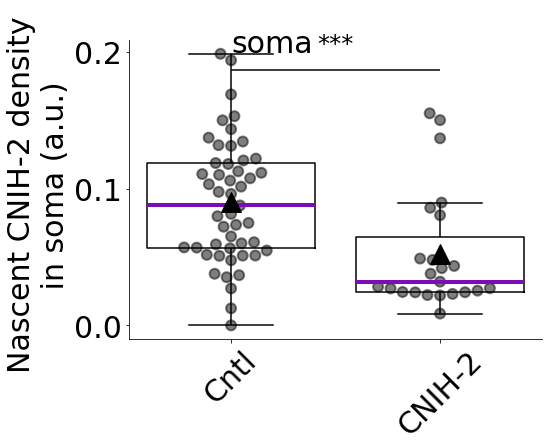

In [49]:
# compart = compartments[0]
# unit_string = {compartments[0]:"in {} / $\mu m^2$".format(compartments[0]),compartments[1]:"{} / $ \mu m$".format(compartments[1])}

# for compart in compartments:
xlab = ""
title = ""#subu#"{}".format(compart)
ylab = "Nascent CNIH-2 density \n in soma (a.u.)"
# print("Subunit = {}".format(subu),newprot_density[newprot_density.subunit==subu].groupby(["treatment","compartment"])["Density"].mean())
SwarmBoxCombo(newprot_density,
              x = "compartment",
              y = "Density",
              fbase="Fig_cnih2_shrna_validation_protein",
              xlabel=xlab,
              ylabel=ylab,
              title=title,
              Num = False,
             pairs=[[1,2]])


In [50]:
newmrna_counts = CNIH_mRNA_val_data.groupby(["cell_id","treatment","compartment"]).count().PID
newmrna_counts

cell_id  treatment  compartment
1        CNIH2      soma           165
         cntl       soma           201
2        CNIH2      soma            20
         cntl       soma           190
3        CNIH2      soma             9
         cntl       soma           184
4        CNIH2      soma             3
         cntl       soma           373
5        CNIH2      soma             6
         cntl       soma           214
6        CNIH2      soma             5
         cntl       soma           113
7        CNIH2      soma            45
         cntl       soma           550
8        CNIH2      soma            14
         cntl       soma           206
9        CNIH2      soma             4
10       CNIH2      soma             6
11       CNIH2      soma             4
12       CNIH2      soma             3
13       CNIH2      soma            15
14       CNIH2      soma            36
15       CNIH2      soma           131
16       CNIH2      soma             1
17       CNIH2      soma        

In [51]:
mRNAROI_areas = cell_roi_mRNA_meta_data.sum().ROI_AOL
mRNAROI_areas

cell_id  treatment  compartment
1        CNIH2      soma           12.781003
         cntl       soma            9.508344
2        CNIH2      soma           10.108018
         cntl       soma            7.620966
3        CNIH2      soma           10.930889
         cntl       soma           12.882806
4        CNIH2      soma           13.346871
         cntl       soma           13.939630
5        CNIH2      soma           12.394538
         cntl       soma            8.898682
6        CNIH2      soma            5.617188
         cntl       soma            5.189617
7        CNIH2      soma            9.845637
         cntl       soma           22.897473
8        CNIH2      soma           18.148487
         cntl       soma            8.144576
9        CNIH2      soma           14.971099
10       CNIH2      soma            8.187218
11       CNIH2      soma            9.361979
12       CNIH2      soma            9.529089
13       CNIH2      soma           12.529763
14       CNIH2      som

In [52]:
newmrna_density = newmrna_counts/mRNAROI_areas
# newprot_density = newprot_density.dropna()
# newprot_density 
newmrna_density = newmrna_density.reset_index()
newmrna_density = newmrna_density.rename(columns={0:'Density'})
newmrna_density['Density'].fillna(value = 0,  inplace = True)
newmrna_density["Density"] = newmrna_density["Density"] 
# newprot_counts = newprot_counts.


1.2801843465459026e-06 (2,)
1.2801843465459026e-06
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20047/3192663891.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20047/3192663891.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


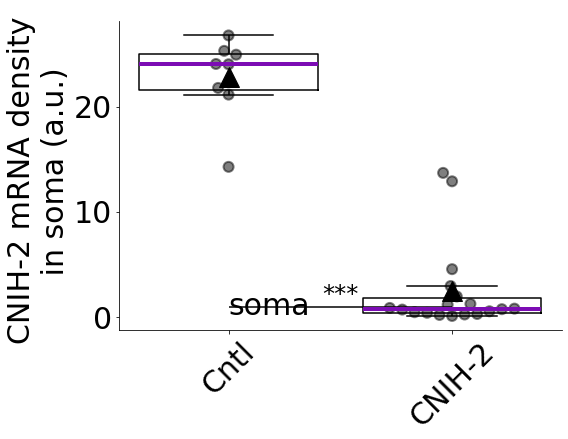

In [53]:
# compart = compartments[0]
# unit_string = {compartments[0]:"in {} / $\mu m^2$".format(compartments[0]),compartments[1]:"{} / $ \mu m$".format(compartments[1])}

# for compart in compartments:
xlab = ""
title = ""#subu#"{}".format(compart)
ylab = "CNIH-2 mRNA density \n in soma (a.u.)"
# print("Subunit = {}".format(subu),newprot_density[newprot_density.subunit==subu].groupby(["treatment","compartment"])["Density"].mean())
SwarmBoxCombo(newmrna_density,
              x = "compartment",
              y = "Density",
              fbase="Fig_cnih2_shrna_validation_mrna",
              xlabel=xlab,
              ylabel=ylab,
              title=title,
              Num = False,
             pairs=[[1,2]])
